<a href="https://colab.research.google.com/github/ysgrProgramming/salesman_problem/blob/main/salesman_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 巡回セールスマン問題の$O(n^2 2^n)$解法

目的：bitDPを用いて巡回セールスマン問題を解くアルゴリズムについて学習する。

## 座標生成

巡回するためには頂点が必要となるので、ランダムに頂点座標の組を生成する関数を作成する。

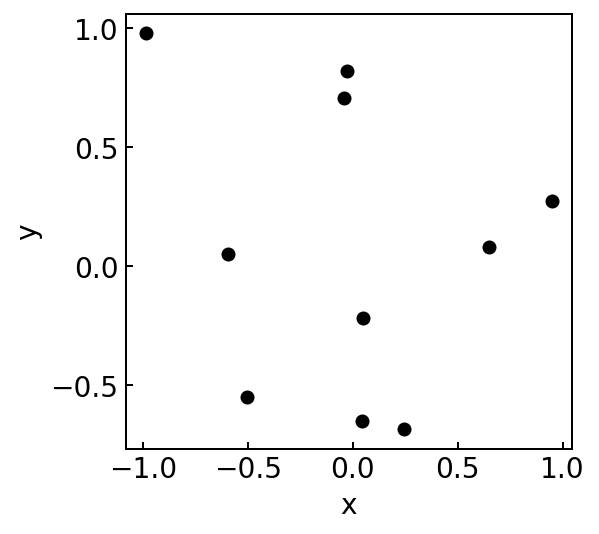

In [3]:
import numpy as np
import matplotlib.pyplot as plt

config = {
    'font.family':'Yu Mincho',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'font.size': 14,
    'axes.linewidth': 1.0,
    'figure.figsize': (4, 4),
    'figure.dpi': 144
}
plt.rcParams.update(config)

def generate_coordinates(n, x_size, y_size):
    x = np.random.rand(n)*x_size-(x_size/2)
    y = np.random.rand(n)*y_size-(y_size/2)
    cd = (x, y)
    return cd

node_size = 10

x, y = generate_coordinates(node_size, 2, 2)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y, "ko")

## 各点同士の距離を記録する

各点同士の距離を測り、対応表となるようなリストを生成する。

In [4]:
import pandas as pd

def meajure_dist(x_list, y_list):
    dist_list = []
    for x1, y1 in zip(x_list, y_list):
        part_list = []
        for x2, y2 in zip(x_list, y_list):
            part_list.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
        dist_list.append(part_list)
    return dist_list

dist_list = meajure_dist(x, y)
pd.DataFrame(dist_list)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.202976,0.558420,1.360078,1.474188,0.947793,0.948401,0.434355,1.926260,1.292107
1,0.202976,0.000000,0.761368,1.419157,1.529339,1.114125,0.863608,0.506740,2.066569,1.186980
2,0.558420,0.761368,0.000000,1.339697,1.453175,0.606167,1.315160,0.645914,1.601136,1.669979
3,1.360078,1.419157,1.339697,0.000000,0.116116,0.859318,0.933276,0.927346,0.982303,1.080522
4,1.474188,1.529339,1.453175,0.116116,0.000000,0.959191,1.003983,1.040805,0.971992,1.118463
5,0.947793,1.114125,0.606167,0.859318,0.959191,0.000000,1.244755,0.695393,1.006799,1.558986
6,0.948401,0.863608,1.315160,0.933276,1.003983,1.244755,0.000000,0.670473,1.865543,0.355615
7,0.434355,0.506740,0.645914,0.927346,1.040805,0.695393,0.670473,0.000000,1.578807,1.024477
8,1.926260,2.066569,1.601136,0.982303,0.971992,1.006799,1.865543,1.578807,0.000000,2.058171
9,1.292107,1.186980,1.669979,1.080522,1.118463,1.558986,0.355615,1.024477,2.058171,0.000000


## 最短経路を求める

本題。bitDPを使って最短経路を求める。

### テーブルの作成

$dp[S][v](S=要素の集合、v=最後に到達する頂点)$を、頂点0から始まり集合$S$の頂点全てを通り頂点$v$に到達する最短経路とする。

初期条件は$dp[0][0]=0$

漸化式を

$dp[S \cup v][v]=min(dp[S \cup v][v], dp[S][k]+cost[k][v])$

と定めると、$dp[-1][0]$が頂点0から全ての要素を通り頂点0に戻る最短経路の距離となる。

In [5]:
def make_table(node_size, dist_list):
    dp = [[float('inf')]*node_size for _ in range(1<<node_size)]
    dp[0][0] = 0
    for bit in range(1<<node_size):
        for i in range(node_size):
            if dp[bit][i] == float('inf'): continue
            for j in range(node_size):
                if bit & 1<<j: continue
                dp[bit ^ 1<<j][j] = min(dp[bit ^ 1<<j][j], dp[bit][i]+dist_list[i][j])
    return dp

dp = make_table(node_size, dist_list)
dp[-1][0]

6.075819016543628

### dpテーブルから経路を逆算

初期状態を$(S, v)=$(要素すべての集合、$0$)から始め、$v$を記録し、$S$から$v$を消去した集合の中での最短距離となる$v$を探す。これを繰り返すことにより最短経路となる頂点の順番が記録される。

In [6]:
def find_shortest_sort(node_size, dp, dist_list):
    s = (1<<node_size)-1
    li = [0]
    s -= 1
    for _ in range(node_size-1):
        min_length, min_node = float('inf'), -1
        for j in range(1, node_size):
            if s & 1<<j == 0: continue
            if dp[s][j]+dist_list[j][li[-1]] < min_length:
                min_length = dp[s][j]+dist_list[j][li[-1]]
                min_node = j
        li.append(min_node)
        s -= 1<<min_node
    return li

li = find_shortest_sort(node_size, dp, dist_list)
print(li)


[0, 2, 5, 8, 4, 3, 9, 6, 7, 1]


### 最短経路の視覚化

どの順番に頂点を辿ればよいか求められたので、図示する。

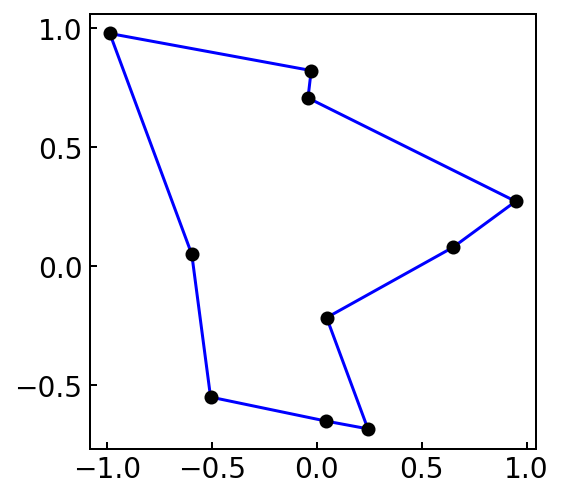

In [7]:
def plt_route(li, x_list, y_list):
    li = np.array(li)
    x_list, y_list = x_list[li], y_list[li]
    plt.plot(x_list, y_list, "b-")
    plt.plot([x_list[0], x_list[-1]], [y_list[0], y_list[-1]], "b-")
    plt.plot(x_list, y_list, "ko")

plt_route(li, x, y)

## ランダムシミュレーション

任意の頂点数から頂点をランダムに配置し、最短巡回経路を図示する

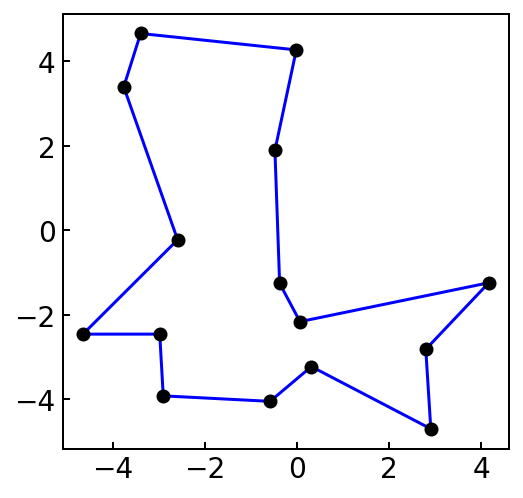

In [8]:
def salesman_simulate(node_size):
    if node_size <= 0: raise Exception("node_size is too short")
    x, y = generate_coordinates(node_size, 10, 10)
    dist_list = meajure_dist(x, y)
    dp = make_table(node_size, dist_list)
    li = find_shortest_sort(node_size, dp, dist_list)
    plt_route(li, x, y)

salesman_simulate(15)